![QBSS](imgs/header.png)

<hr>

[Spencer Churchill](https://splch.github.io)

In [1]:
# imports for RSA
from numpy import pi, gcd
from numpy.random import seed, randint

# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

# Introduction

“I have lucrative news to share before it goes public... don’t worry, I encrypted the listing. See you soon.” 

You look up to see a man hastily exit the NY subway, leaving behind a scrap of paper in the aisle. Curious, you read the contents of the slip:

![Paper Scrap](imgs/scrap.png)

“Buy `213` stock!”

On the bottom, you see what you can only assume is the coprime of an RSA key, `, 15)`

In [2]:
code = 213
N = 15

In [3]:
print(f"You know 3 things:\n\t1. a company is going to report high earnings,",
      f"\n\t2. that company's encrypted stock listing is `{code}`, and",
      f"\n\t3. the key's coprime, N, is {N}.")

You know 3 things:
	1. a company is going to report high earnings, 
	2. that company's encrypted stock listing is `213`, and 
	3. the key's coprime, N, is 15.


# RSA Algorithm

In [4]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!

    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2.",
                         f"{P} and {Q} are incompatible with Shor's Algorithm.")

    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)

    for E in range(2, L): # between [2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

def dec(code, key):
    D, N = key
    return "".join([chr(((d**D) % N) + ord('A'))
                    for d in [int(d) for d in str(code)]])

The prospect of cracking an insider trade is too compelling to ignore, so you try to guess the private key.

In [5]:
P = Q = 0

print("Guesses:")
for i in range(0, 5, 2):
    print(f"\t{i//2 + 1}. {dec(code, (i, N))}")

Guesses:
	1. BBB
	2. EBJ
	3. BBG


However, RSA is too secure to simply be guessed. The asymmetric modular function is constructed in such a way as to only allow the private key to unlock the encryption. The scrap only has the coprime factor of the key though.

![RSA Keys](imgs/keys.png)

The only way to read the listing would be to

1. factor the coprime number,
2. use those factors to generate the private key,
3. then decrypt the listing with the private key.

Luckily, you attended Abe's lecture on Shor's algorithm and know exactly how to begin!

# Shor's Algorithm

You review and write out each step from the notes

## Pick an integer, $a$, such that $1 < a < N$ and $gcd(a, N) = 1$.

In [6]:
seed(1)

a = randint(2, N) # 1 < a < N

if gcd(a, N) == 1: # a shares no factors
    print(f"{1} < {a} < {N}, {1 < a < N}")
else: # a shares a factor
    P = gcd(a, N)
    Q = N // gcd(a, N)
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}\n")
    print("You got lucky! You can skip to the Decypting 213 section, I guess. 😂")

1 < 7 < 15, True


## Find the period of $$f(x) = a^x \text{ mod } N\text{, where x is the period of the function }$$

This is when you connect to your [quantum computer](https://quantum-computing.ibm.com/) and begin making your period-finding circuit.

![Quantum Circuit](imgs/circuit.png)

**First**, you notice the measurement qubits, $\vert0\rangle^{\otimes n}$, are all being initialized with Hadamard ($H$) gates and the target qubits are being initialized at $\vert1\rangle^{\otimes n}$.

In [7]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

**Second**, you see U gates applying a unitary operator, $U(x) = a^x \text{ mod } N$, on the target qubits controlled by the measurement qubits.

In [8]:
print(f"Which in your case is\n\tU(x) = a^x mod {N}")

Which in your case is
	U(x) = a^x mod 15


In [9]:
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

In [10]:
def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

**Third**, you perform an inverse quantum Fourier transform on the measurement qubits.

In [11]:
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                             do_swaps=False).inverse(),
                         measurement_qubits)

**Fourth**, you measure the measurement qubits to hopefully return an exponent, $x$, which satisfies $f(x) = a^x \text{ mod } N$.

In [12]:
def measure(qc, n):
    qc.measure(n, n)

Finally, you assemble the circuit,

In [13]:
def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

run it,

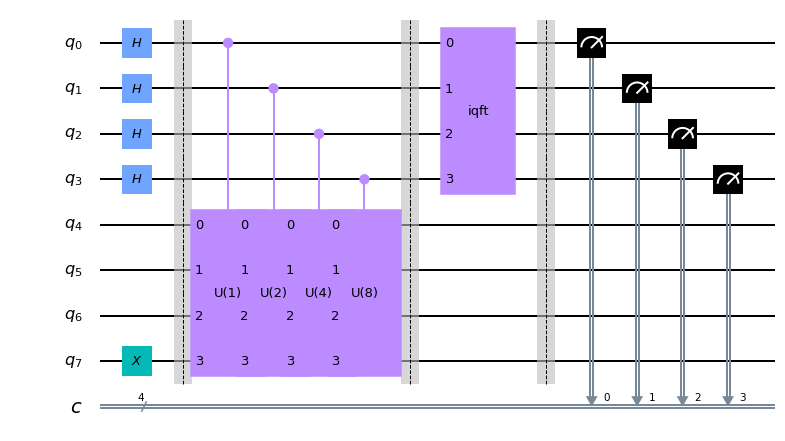

In [14]:
n = 4; m = 4

qc = period_finder(n, m, a)
qc.draw(output='mpl')

and return possible exponents for period finding.

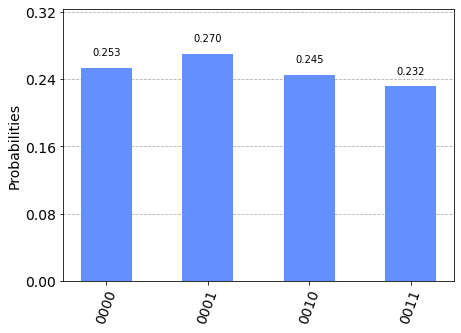

In [15]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator).result().get_counts(qc)

plot_histogram(counts)

In [16]:
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	4	8	12	

# Factoring N

Now, you sort through the possible exponents, finding those which satisfy 2 constraints:

1. the exponent, $x$, must be even and
2. $a^{\frac x2} + 1 \neq 0 \text{ mod } N$

In [17]:
periods = []

for measured_value in counts_dec:
    if measured_value % 2 == 0: # x is even
        if (int((a ** (measured_value/2))) + 1) % N != 0:
            periods.append(measured_value)

Using an applicable period, $x$, you can find a nontrivial factors, $P$ and $Q$, of $N$ with $$gcd(a^{\frac x2} \pm 1, N)$$

In [18]:
factors = set()

for x in periods:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5

 3 x 5 = 15, True


# Decrypting `213`

This is the moment you've been waiting for! Quickly, you use the factors $P$ and $Q$ to generate the incomplete private key.

In [19]:
_, priv_key = rsa(P, Q)
print("Using RSA and Shor's Algorithm,",
      f"you determine the private key to be:\n\t{priv_key}")

Using RSA and Shor's Algorithm, you determine the private key to be:
	(23, 15)


Descrypting the listing is only one function away now... You hesitate, but eventually run the cell below.

In [20]:
dec_str = dec(code, priv_key)
print(f"You learn that the decrypted listing is {dec_str}!")

You learn that the decrypted listing is IBM!


Being the great quantum programmer you are, you decide (not) to buy the stock. Knowing you did the right thing, you enjoy the rest of your day.

*Tune in next week to learn how to use Grover's algorithm to search through your wallet!*

Thank you for reading this story! I had the privilege of attending Abe Asfaw's lectures on Shor's Algorithm during the Qiskit Global Summer School. By the fourth day, we were assigned a lab factoring the coprime 15. This inspired me to demonstrate Shor's algorithm applied to a "realistic" situation. I spent two weeks of my quarantine having fun and learning so much from the many lecturers, mentors, and peers contributing on Crowdcast and Discord. If you'd like to learn more about Shor's algorithm (under the hood), check out the Qiskit Textbook.

Thank you again to everyone who made the Qiskit Global Summer School possible and those who enjoyed reading this blog.

# Sources

- [RSA Tutorial](https://hackernoon.com/how-does-rsa-work-f44918df914b)
- [Qiskit Textbook - Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html)
- [Qiskit Lecture](https://www.crowdcast.io/e/qgss-day4)
- [Period Finding Steps](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure)
